In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00


In [2]:
import os
import urllib.request
import zipfile
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception
from keras_preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight

In [3]:
# Download & Ekstrak Dataset
data_url = 'https://drive.usercontent.google.com/download?id=1T2vteOAvBrj23MK3ry_ynLWli4_gNbqe&export=download&confirm=t'
urllib.request.urlretrieve(data_url, 'Datasets.zip')
with zipfile.ZipFile('Datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('Datasets')

base_dir = 'Datasets'

In [4]:
# ImageDataGenerator (Augmentasi & Preprocessing)
train_path = os.path.join(base_dir, "Dataset/train")
val_path = os.path.join(base_dir, "Dataset/validation")
test_path = os.path.join(base_dir, "Dataset/test")

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 1062 images belonging to 3 classes.
Found 298 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [5]:
# Load Pre-trained Model (Xception)
pre_trained_model = Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

# Fine-tune sebagian kecil layer (transfer learning)
for layer in pre_trained_model.layers[:-30]:
    layer.trainable = False
for layer in pre_trained_model.layers[-30:]:
    layer.trainable = True

last_layer_output = pre_trained_model.output
print(f'Output shape of the Xception base model: {last_layer_output.shape}')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Output shape of the Xception base model: (None, 10, 10, 2048)


In [6]:
# Perhitungan Class Weight
labels = train_generator.classes
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))

# Model Architecture (Custom Head)
x = layers.GlobalAveragePooling2D()(last_layer_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['acc']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('Xception_model.h5', monitor='val_acc', save_best_only=True, verbose=1)

# Training
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.3719 - loss: 1.1028
Epoch 1: val_acc improved from -inf to 0.64765, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - acc: 0.3737 - loss: 1.1019 - val_acc: 0.6477 - val_loss: 0.9914 - learning_rate: 5.0000e-05
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.5807 - loss: 0.9627
Epoch 2: val_acc improved from 0.64765 to 0.66779, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.5818 - loss: 0.9618 - val_acc: 0.6678 - val_loss: 0.8413 - learning_rate: 5.0000e-05
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.6435 - loss: 0.8257
Epoch 3: val_acc improved from 0.66779 to 0.73154, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.6443 - loss: 0.8245 - val_acc: 0.7315 - val_loss: 0.6542 - learning_rate: 5.0000e-05
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7512 - loss: 0.6715
Epoch 4: val_acc improved from 0.73154 to 0.75839, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.7513 - loss: 0.6704 - val_acc: 0.7584 - val_loss: 0.5484 - learning_rate: 5.0000e-05
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7848 - loss: 0.5599
Epoch 5: val_acc improved from 0.75839 to 0.81544, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.7839 - loss: 0.5607 - val_acc: 0.8154 - val_loss: 0.4552 - learning_rate: 5.0000e-05
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8171 - loss: 0.5075
Epoch 6: val_acc improved from 0.81544 to 0.81879, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.8168 - loss: 0.5075 - val_acc: 0.8188 - val_loss: 0.4109 - learning_rate: 5.0000e-05
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7813 - loss: 0.5136
Epoch 7: val_acc improved from 0.81879 to 0.82886, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.7820 - loss: 0.5127 - val_acc: 0.8289 - val_loss: 0.3899 - learning_rate: 5.0000e-05
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8239 - loss: 0.4422
Epoch 8: val_acc improved from 0.82886 to 0.84899, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.8239 - loss: 0.4421 - val_acc: 0.8490 - val_loss: 0.3589 - learning_rate: 5.0000e-05
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8392 - loss: 0.4264
Epoch 9: val_acc improved from 0.84899 to 0.85906, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.8393 - loss: 0.4259 - val_acc: 0.8591 - val_loss: 0.3483 - learning_rate: 5.0000e-05
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8486 - loss: 0.3884
Epoch 10: val_acc did not improve from 0.85906
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.8488 - loss: 0.3882 - val_acc: 0.8591 - val_loss: 0.3500 - learning_rate: 5.0000e-05
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8615 - loss: 0.3615
Epoch 11: val_acc improved from 0.85906 to 0.86242, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.8616 - loss: 0.3612 - val_acc: 0.8624 - val_loss: 0.3394 - learning_rate: 5.0000e-05
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8701 - loss: 0.3460
Epoch 12: val_acc did not improve from 0.86242
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.8698 - loss: 0.3466 - val_acc: 0.8624 - val_loss: 0.3170 - learning_rate: 5.0000e-05
Epoch 13/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8909 - loss: 0.3187
Epoch 13: val_acc improved from 0.86242 to 0.86913, saving model to Xception_model_v4.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.8905 - loss: 0.3186 - val_acc: 0.8691 - val_loss: 0.3248 - learning_rate: 5.0000e-05
Epoch 14/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8752 - loss: 0.2990
Epoch 14: val_acc did not improve from 0.86913
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - acc: 0.8755 - loss: 0.2994 - val_acc: 0.8591 - val_loss: 0.3245 - learning_rate: 5.0000e-05
Epoch 15/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8986 - loss: 0.2904
Epoch 15: val_acc did not improve from 0.86913
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.8984 - loss: 0.2909 - val_acc: 0.8591 - val_loss: 0.3218 - learning_rate: 5.0000e-05
Epoch 16/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8953 - loss: 0.2793
Epoch 16: val_acc did not improve from 0.86913
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.8955 - loss: 0.2789 - val_acc: 0.8658 - val_loss: 0.2851 - learning_rate: 5.0000e-05
Epoch 17/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8938 - loss: 0.2807
Epoch 1

34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.9177 - loss: 0.2142 - val_acc: 0.8893 - val_loss: 0.3111 - learning_rate: 5.0000e-05
Epoch 21/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9275 - loss: 0.1928
Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: val_acc did not improve from 0.88926
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.9274 - loss: 0.1929 - val_acc: 0.8758 - val_loss: 0.3111 - learning_rate: 5.0000e-05
Epoch 22/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9500 - loss: 0.1518
Epoch 22: val_acc did not improve from 0.88926
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.9498 - loss: 0.1523 - val_acc: 0.8758 - val_loss: 0.3137 - learning_rate: 1.0000e-05
Epoch 23/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9351 - loss: 0.1775
Epoch 23: val_acc did not improve from 0.88926
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.9350 - loss: 0.1775 - val_acc: 0.8725 - val_loss: 0.3200 - learning_rate: 1.0000e-05
Epoch 24/

In [8]:
train_path = os.path.join(base_dir, "Dataset/train")
val_path = os.path.join(base_dir, "Dataset/validation")
test_path = os.path.join(base_dir, "Dataset/test")

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical'
)

model = tf.keras.models.load_model('Xception_model.h5')

train_loss, train_acc = model.evaluate(train_generator, verbose=1)
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print(f"Train Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

Found 1062 images belonging to 3 classes.
Found 298 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - acc: 0.9598 - loss: 0.1139
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 9s/step - acc: 0.8831 - loss: 0.3231
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 9s/step - acc: 0.8483 - loss: 0.4407
Train Accuracy: 0.9605, Loss: 0.1129
Validation Accuracy: 0.8893, Loss: 0.3111
Test Accuracy: 0.8467, Loss: 0.4333


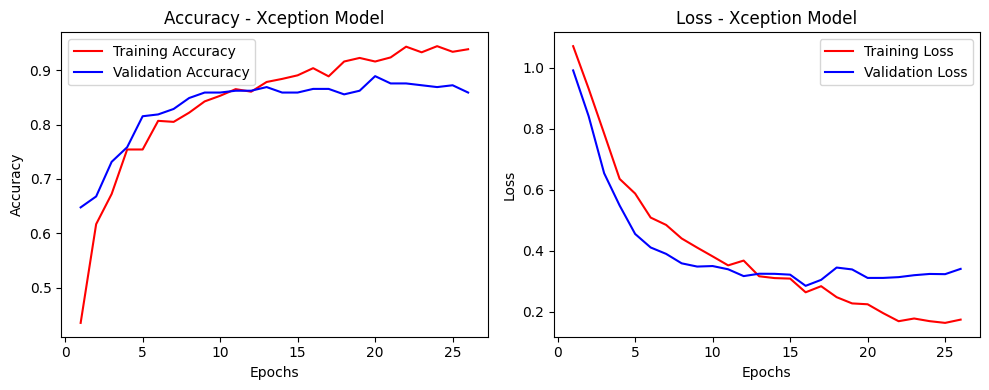

In [9]:
import matplotlib.pyplot as plt

# Ambil riwayat dari training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Akurasi
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy - Xception Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss - Xception Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [11]:
def load_and_process_image(image_path, target_size=(299, 299)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

def load_test_data(test_dir, class_names):
    data = []
    labels = []
    class_mapping = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: Folder {class_path} not found.")
            continue
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                data.append(load_and_process_image(image_path))
                labels.append(class_mapping[class_name])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    return np.array(data), np.array(labels)

Error loading image Datasets/Dataset/validation/Bagus/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7bce4cbdd170>
Error loading image Datasets/Dataset/validation/Rusak Berat/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7bce4cd7fc90>
Error loading image Datasets/Dataset/validation/Rusak Ringan/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7bce999c3bf0>


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step


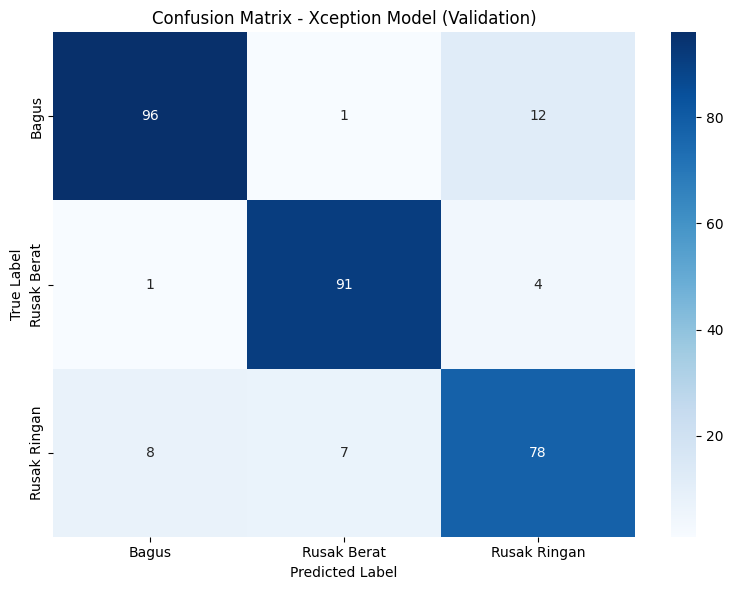


Classification Report (Validation Data):
              precision    recall  f1-score   support

       Bagus       0.91      0.88      0.90       109
 Rusak Berat       0.92      0.95      0.93        96
Rusak Ringan       0.83      0.84      0.83        93

    accuracy                           0.89       298
   macro avg       0.89      0.89      0.89       298
weighted avg       0.89      0.89      0.89       298



In [12]:
test_data_dir = val_path
class_names = sorted(os.listdir(test_data_dir))
X_test, y_test = load_test_data(test_data_dir, class_names)

model = keras.models.load_model('Xception_model.h5')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(to_categorical(y_test, num_classes=len(class_names)), axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Xception Model (Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\nClassification Report (Validation Data):")
print(class_report)

Error loading image Datasets/Dataset/train/Rusak Ringan/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7bcec44c9300>
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step


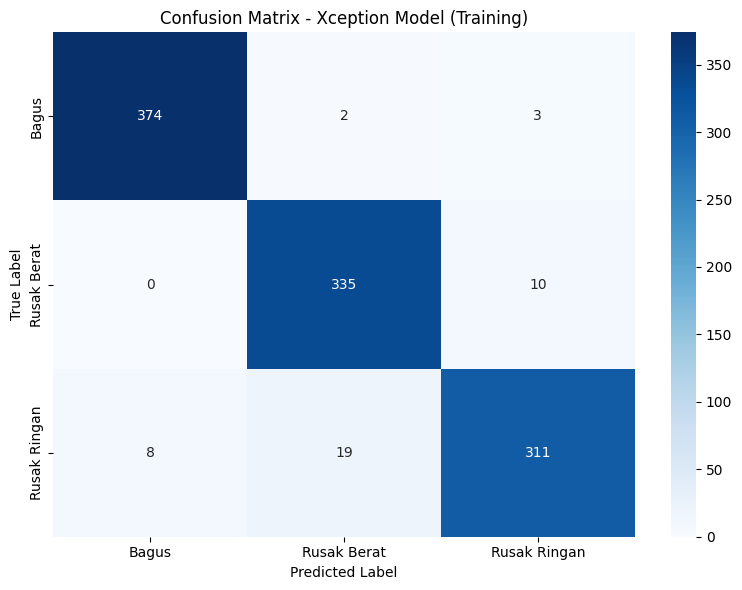


Classification Report (Training Data):
              precision    recall  f1-score   support

       Bagus       0.98      0.99      0.98       379
 Rusak Berat       0.94      0.97      0.96       345
Rusak Ringan       0.96      0.92      0.94       338

    accuracy                           0.96      1062
   macro avg       0.96      0.96      0.96      1062
weighted avg       0.96      0.96      0.96      1062



In [13]:
test_data_dir = train_path
class_names = sorted(os.listdir(test_data_dir))
X_test, y_test = load_test_data(test_data_dir, class_names)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(to_categorical(y_test, num_classes=len(class_names)), axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Xception Model (Training)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\nClassification Report (Training Data):")
print(class_report)

Error loading image Datasets/Dataset/test/Bagus/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7bce4ca4dd00>
Error loading image Datasets/Dataset/test/Rusak Berat/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7bcec44f6b10>
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step


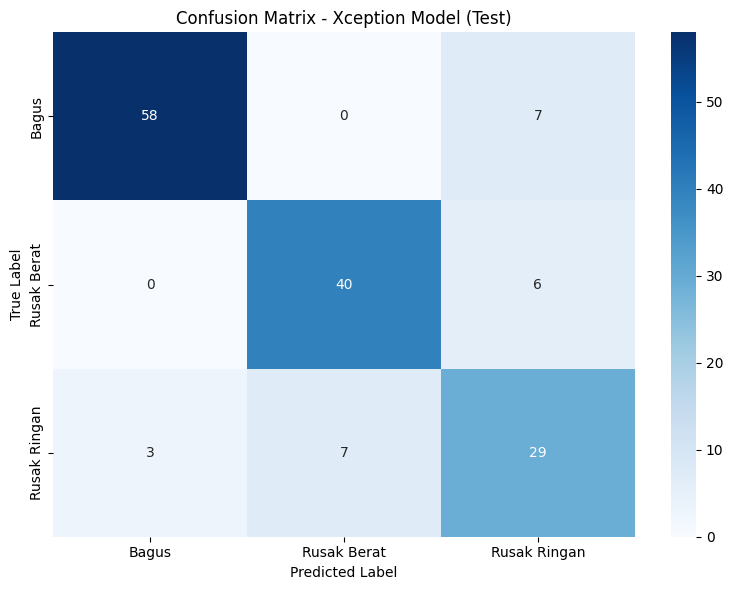


Classification Report (Test Data):
              precision    recall  f1-score   support

       Bagus       0.95      0.89      0.92        65
 Rusak Berat       0.85      0.87      0.86        46
Rusak Ringan       0.69      0.74      0.72        39

    accuracy                           0.85       150
   macro avg       0.83      0.84      0.83       150
weighted avg       0.85      0.85      0.85       150



In [14]:
test_data_dir = test_path
class_names = sorted(os.listdir(test_data_dir))
X_test, y_test = load_test_data(test_data_dir, class_names)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(to_categorical(y_test, num_classes=len(class_names)), axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Xception Model (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\nClassification Report (Test Data):")
print(class_report)